In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# neural network stuff
class layer:
    'Neural network dense layer'
    
    # initialization (weights and biases)
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01*np.random.randn(n_inputs, n_neurons) 
        self.biases = np.zeros((1,n_neurons))

    # output
    def forward(self, inputs):
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
      
    def backward(self, dvalues):
        
        # gradient
        self.dinputs = dvalues.dot(self.weights.T)
        
        # Gradients on parameters
        self.dweights = self.inputs.T.dot(dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)


class dropout:
    'dropout layer'
    
    # initialization - set the dropout rate
    def __init__(self, rate):
        self.rate = rate
        
    # forward pass
    def forward(self, inputs):
        # save inputs 
        self.inputs = inputs
        # mask
        self.mask = np.random.binomial(1, 1 - self.rate, size = inputs.shape) / (1 - self.rate)
        # apply mask
        self.output = inputs * self.mask
        
    # backward pass
    def backward(self, dvalues):
        self.dinputs = dvalues*self.mask
        
class activation_ReLU:
    'rectified linear unit activation function'
    
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dvalues):

        # copy dvalues
        self.dinputs = dvalues.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
class activation_softmax:
    'softmax activation function'
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs-np.max(inputs,axis=1, keepdims=True))
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
    def backward(self,dvalues):

        
        # initialized gradient (derivative) array
        self.dinputs = np.zeros(dvalues.shape)
        
        # For each data point, compute gradient
        for i in range(len(dvalues)):
            output_row = self.output[i]
            dvalues_row = dvalues[i]
            
            # Flatten output array
            output_row = output_row.reshape(-1, 1)

            # Calculate derivative matrix of the output
            derivative_matrix = np.diagflat(output_row) - output_row.dot(output_row.T)
            
            # store gradient
            self.dinputs[i] = dvalues_row.dot(derivative_matrix)


class loss:
    def calculate(self, output,y):
        sample_losses = self.forward(output,y)
        loss = np.mean(sample_losses)
        return loss
    
# cross-entropy loss        
class loss_crossentropy(loss):
    
    def forward(self, y_pred, y_true):
        
        # number of data points
        n_samples = len(y_pred)
        
        # clip data to prevent division by 0
        y_pred_clipped = np.clip(y_pred, 1e-7,1 - 1e-7)
        
        # confidence values
        confidence_values = y_pred_clipped[range(n_samples),y_true]
       
        # sample losses 
        losses = -np.log(confidence_values)
        return losses
    
    
    def backward(self, dvalues, y_true):
        
        
        # Number of samples
        n_samples = len(dvalues)
    
        #one-hot matrix
        Y = np.zeros(dvalues.shape)
        Y[np.arange(len(y_true)),y_true] = 1
        
        # Calculate gradient
        self.dinputs = -Y / dvalues
        
        # Normalize gradient
        self.dinputs = self.dinputs / n_samples
        
# GD optimizer
class optimizer_GD:

    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases
        
# Adam optimizer
class optimizer_Adam:
    
    # Initialize optimizer - set parameters
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
        
        # learning rate
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        
        # decay parameters
        self.decay = decay
        
        # number of epochs
        self.epoch = 0
        
        # update learning rate parameter
        self.epsilon = epsilon
        
        # momentum parameter
        self.beta_1 = beta_1
        
        # cache parameter
        self.beta_2 = beta_2
        
        
    # update learning rate
    def pre_update_parameters(self):
        
        # update learning rate
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.epoch))
            
    # Update weights/biases
    def update_parameters(self, layer):
        
        # If layer does not contain cache/momentum arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            
            # weights
            layer.weight_momentums = np.zeros(layer.weights.shape)
            layer.weight_cache = np.zeros(layer.weights.shape)
            
            # biases
            layer.bias_momentums = np.zeros(layer.biases.shape)
            layer.bias_cache = np.zeros(layer.biases.shape)
            
        # momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # corrected momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        
        # cache
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2  
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        
        # corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.epoch + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.epoch + 1))
        
        # update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
        
    # update epoch
    def post_update_parameters(self):
        self.epoch += 1

## Example 1: The labeled faces in the wild dataset

In [130]:
# Run this cell to load the Labeled Faces in the Wild people dataset
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

X = lfw_people.data/255
y = lfw_people.target

target_names = lfw_people.target_names
n_classes = target_names.shape[0]

There are 1288 images, and each image has 1850 features. This is because each image is 50x37 pixels, and each feature simply represents one pixel's intensity.

In [ ]:
X.shape

(-0.5, 36.5, 49.5, -0.5)

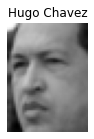

In [131]:
plt.figure(figsize=(2,2))
some_face = X[0]
some_face_image = some_face.reshape(50,37)
plt.imshow(some_face_image,cmap='gray')
plt.title(target_names[y[0]])
plt.axis('off')

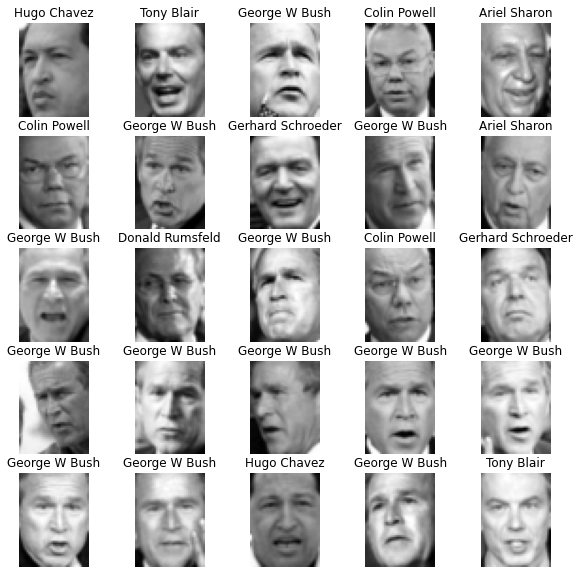

In [132]:
plt.figure(figsize=(10,10))
for i in range(25):
    face = X[i]
    face_image = face.reshape(50,37)
    plt.subplot(5,5,i+1)
    plt.imshow(face_image,cmap = 'gray')
    plt.title(target_names[y[i]])
    plt.axis('off')    

Labels:

- 0:	Ariel Sharon
- 1:	Colin Powell
- 2:	Donald Rumsfeld
- 3:	George W Bush
- 4:	Gerhard Schroeder
- 5:	Hugo Chavez
- 6:	Tony Blair

In [134]:
# shuffle the data
permutation = np.random.permutation(len(y))
X = X[permutation]
y = y[permutation]
# train/test split
X_train, y_train = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [135]:
# neural network 
layer1 = layer(n_inputs = 1850, n_neurons = 100)
activation1 = activation_ReLU()
dropout1 = dropout(.3)
layer2 = layer(n_inputs = 100, n_neurons = 7)
activation2 = activation_softmax()
loss_function = loss_crossentropy()

In [136]:
# optimizer
optimizer = optimizer_Adam() 

In [137]:
n_epochs = 1000
loss_adam = np.zeros(n_epochs)
accuracy_adam = np.zeros(n_epochs)
for i in range(n_epochs):
    
    # forward pass
    layer1.forward(X_train)
    activation1.forward(layer1.output)
    dropout1.forward(activation1.output)
    layer2.forward(dropout1.output)
    activation2.forward(layer2.output)
    
    # loss
    losses = loss_function.forward(activation2.output,y_train)
    loss_adam[i] = np.mean(losses)
    
    # accuracy
    y_pred = np.argmax(activation2.output,axis=1)
    accuracy_adam[i] = 100*np.sum(y_pred == y_train)/len(y_train)
    
    # backward pass
    loss_function.backward(activation2.output,y_train)
    activation2.backward(loss_function.dinputs)
    layer2.backward(activation2.dinputs)
    dropout1.backward(layer2.dinputs)
    activation1.backward(dropout1.dinputs)
    layer1.backward(activation1.dinputs)
    
    # update weights and biases
    optimizer.pre_update_parameters()
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.post_update_parameters()
    
    # print loss and accuracy every 100 epochs
    if i % 100 == 0:
        print('epoch: '+str(i))
        print('loss: '+str(np.round(loss_adam[i],3)))
        print('accuracy: '+str(np.round(accuracy_adam[i],3)))
        print('------------------------')

epoch: 0
loss: 1.945
accuracy: 11.375
------------------------
epoch: 100
loss: 1.112
accuracy: 56.75
------------------------
epoch: 200
loss: 0.581
accuracy: 83.0
------------------------
epoch: 300
loss: 0.375
accuracy: 89.625
------------------------
epoch: 400
loss: 0.262
accuracy: 92.25
------------------------
epoch: 500
loss: 0.181
accuracy: 95.875
------------------------
epoch: 600
loss: 0.137
accuracy: 97.125
------------------------
epoch: 700
loss: 0.093
accuracy: 99.25
------------------------
epoch: 800
loss: 0.084
accuracy: 98.625
------------------------
epoch: 900
loss: 0.067
accuracy: 99.25
------------------------


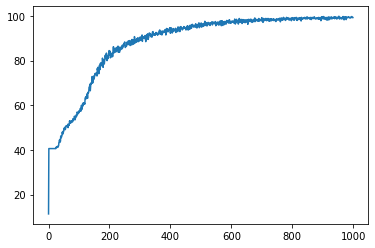

In [138]:
plt.plot(accuracy_adam)

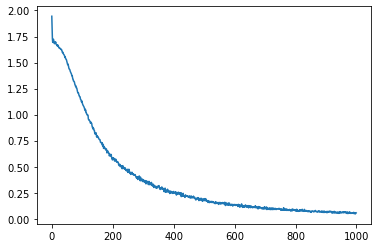

In [139]:
plt.plot(loss_adam)

In [140]:
# forward pass
layer1.forward(X_test)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)

# prediction
y_test_pred = np.argmax(activation2.output,axis=1)

# accuracy
np.sum(y_test==y_test_pred)/len(y_test)

In [143]:
C = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        C[i,j] = np.sum(y_test[y_test_pred==i]==j)
        
C

array([[ 19.,   3.,   1.,   1.,   1.,   0.,   1.],
       [  1.,  70.,   4.,   7.,   1.,   0.,   1.],
       [  1.,   0.,  35.,   5.,   0.,   0.,   2.],
       [  3.,   3.,  10., 188.,   8.,   2.,   4.],
       [  0.,   0.,   2.,   3.,  29.,   3.,   1.],
       [  0.,   0.,   0.,   0.,   0.,  23.,   0.],
       [  2.,   4.,   2.,   1.,   3.,   1.,  43.]])

## Example 2:  Cifar10 dataset

The CIFAR dataset consists of 7000 32x32 color images in 10 classes

In [79]:
cifar = pd.read_csv('cifar.csv')
cifar

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
0,0.231373,0.243137,0.247059,0.168627,0.180392,0.176471,0.196078,0.188235,0.168627,0.266667,...,0.847059,0.721569,0.549020,0.592157,0.462745,0.329412,0.482353,0.360784,0.282353,6
1,0.603922,0.694118,0.733333,0.494118,0.537255,0.533333,0.411765,0.407843,0.372549,0.400000,...,0.560784,0.521569,0.545098,0.560784,0.525490,0.556863,0.560784,0.521569,0.564706,9
2,1.000000,1.000000,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.305882,0.333333,0.325490,0.309804,0.333333,0.325490,0.313725,0.337255,0.329412,9
3,0.109804,0.098039,0.039216,0.145098,0.133333,0.074510,0.149020,0.137255,0.078431,0.164706,...,0.211765,0.184314,0.109804,0.247059,0.219608,0.145098,0.282353,0.254902,0.180392,4
4,0.666667,0.705882,0.776471,0.658824,0.698039,0.768627,0.694118,0.725490,0.796078,0.717647,...,0.294118,0.309804,0.321569,0.278431,0.294118,0.305882,0.286275,0.301961,0.313725,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.674510,0.741176,0.768627,0.658824,0.733333,0.756863,0.658824,0.733333,0.756863,0.658824,...,0.278431,0.482353,0.443137,0.317647,0.517647,0.494118,0.325490,0.533333,0.513725,8
6996,0.396078,0.384314,0.231373,0.380392,0.364706,0.203922,0.396078,0.372549,0.196078,0.427451,...,0.619608,0.564706,0.388235,0.650980,0.580392,0.407843,0.482353,0.415686,0.270588,2
6997,0.286275,0.298039,0.262745,0.286275,0.294118,0.274510,0.305882,0.313725,0.305882,0.305882,...,0.529412,0.568627,0.658824,0.521569,0.568627,0.654902,0.478431,0.537255,0.619608,9
6998,0.976471,0.976471,0.972549,0.956863,0.956863,0.949020,0.976471,0.976471,0.972549,0.976471,...,0.850980,0.843137,0.827451,0.850980,0.839216,0.827451,0.839216,0.835294,0.827451,7


Labels:

- 0: airplane										
- 1: automobile										
- 2: bird										
- 3: cat										
- 4: deer										
- 5: dog										
- 6: frog										-
- 7:  horse										
- 8: ship										
- 9: truck

In [108]:
classes = ['airplane','auto','bird','cat','deer','dog','frog','horse','ship','truck']
classes

['airplane',
 'auto',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [86]:
X = cifar.iloc[:,0:3072].to_numpy()

In [87]:
y = cifar['label'].to_numpy()

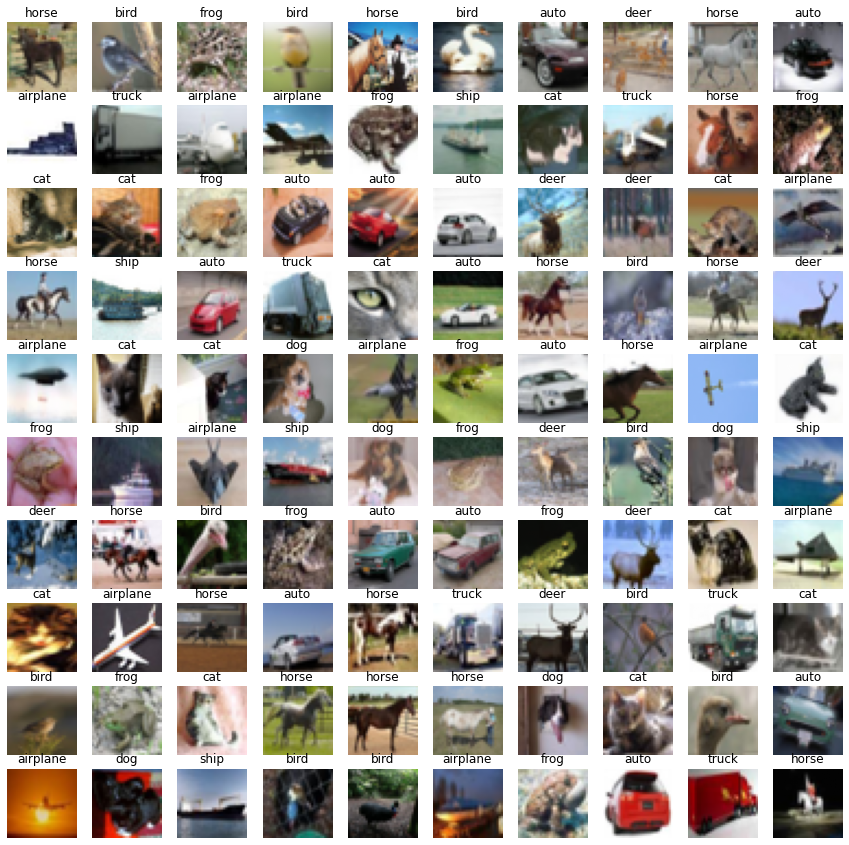

In [120]:
plt.figure(figsize=(15,15))
for i in range(100):
    image = X[i].reshape(32,32,3)
    plt.subplot(10,10,i+1)
    plt.imshow(image)
    plt.title(classes[y[i]])
    plt.axis('off')

In [89]:
# shuffle the data
permutation = np.random.permutation(len(y))
X = X[permutation]
y = y[permutation]

# train/test split
X_train,y_train = X[0:5000],y[0:5000]
X_test,y_test = X[5000:7000],y[5000:7000]

**Challenge**: Can you build a neural network that achieves 50% of accuracy on the test set

### Two layers

In [90]:
X.shape

(7000, 3072)

In [103]:
# neural network 
layer1 = layer(n_inputs = 3072, n_neurons = 100)
activation1 = activation_ReLU()
dropout1 = dropout(.2)
layer2 = layer(n_inputs = 100, n_neurons = 10)
activation2 = activation_softmax()
loss_function = loss_crossentropy()

In [104]:
optimizer = optimizer_Adam()

In [105]:
n_epochs = 500
loss_adam = np.zeros(n_epochs)
accuracy_adam = np.zeros(n_epochs)
for i in range(n_epochs):
    
    # forward pass
    layer1.forward(X_train)
    activation1.forward(layer1.output)
    dropout1.forward(activation1.output)
    layer2.forward(dropout1.output)
    activation2.forward(layer2.output)
    
    # loss
    losses = loss_function.forward(activation2.output,y_train)
    loss_adam[i] = np.mean(losses)
    
    # accuracy
    y_pred = np.argmax(activation2.output,axis=1)
    accuracy_adam[i] = 100*np.sum(y_pred == y_train)/len(y_train)
    
    # backward pass
    loss_function.backward(activation2.output,y_train)
    activation2.backward(loss_function.dinputs)
    layer2.backward(activation2.dinputs)
    dropout1.backward(layer2.dinputs)
    activation1.backward(dropout1.dinputs)
    layer1.backward(activation1.dinputs)
    
    # update weights and biases
    optimizer.pre_update_parameters()
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.post_update_parameters()
    
    # print loss and accuracy every 100 epochs
    if i % 100 == 0:
        print('epoch: '+str(i))
        print('loss: '+str(np.round(loss_adam[i],3)))
        print('accuracy: '+str(np.round(accuracy_adam[i],3)))
        print('------------------------')

epoch: 0
loss: 2.302
accuracy: 10.86
------------------------
epoch: 100
loss: 1.547
accuracy: 46.0
------------------------
epoch: 200
loss: 1.269
accuracy: 56.26
------------------------
epoch: 300
loss: 1.073
accuracy: 63.78
------------------------
epoch: 400
loss: 0.915
accuracy: 69.58
------------------------


KeyboardInterrupt: 

In [106]:
# forward pass
layer1.forward(X_test)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)

# prediction
y_test_pred = np.argmax(activation2.output,axis=1)

# accuracy
np.sum(y_test==y_test_pred)/len(y_test)

0.431

In [107]:
# confusion matrix
C = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        C[i,j] = np.sum(y_test[y_test_pred==i]==j)
        
C

array([[ 91.,  12.,   9.,   7.,   7.,   3.,   3.,  12.,  40.,  17.],
       [  8.,  86.,  10.,  11.,   4.,   2.,   5.,   9.,  15.,  28.],
       [ 19.,   9.,  65.,  19.,  26.,  21.,  30.,  14.,   5.,   6.],
       [ 10.,   5.,  20.,  49.,   7.,  44.,  31.,  12.,   7.,   7.],
       [ 10.,   1.,  25.,  13.,  97.,  16.,  24.,  20.,   7.,   2.],
       [  4.,   7.,   8.,  45.,  10.,  65.,  18.,  12.,   9.,  10.],
       [  4.,   5.,  14.,  22.,  19.,  16.,  98.,   9.,   2.,  10.],
       [  5.,   3.,  10.,   9.,  26.,  14.,   9.,  97.,   1.,  10.],
       [ 34.,  17.,   5.,   5.,   7.,  11.,   3.,   8., 109.,  15.],
       [ 13.,  32.,   6.,  18.,   6.,   4.,   3.,  10.,  18., 105.]])

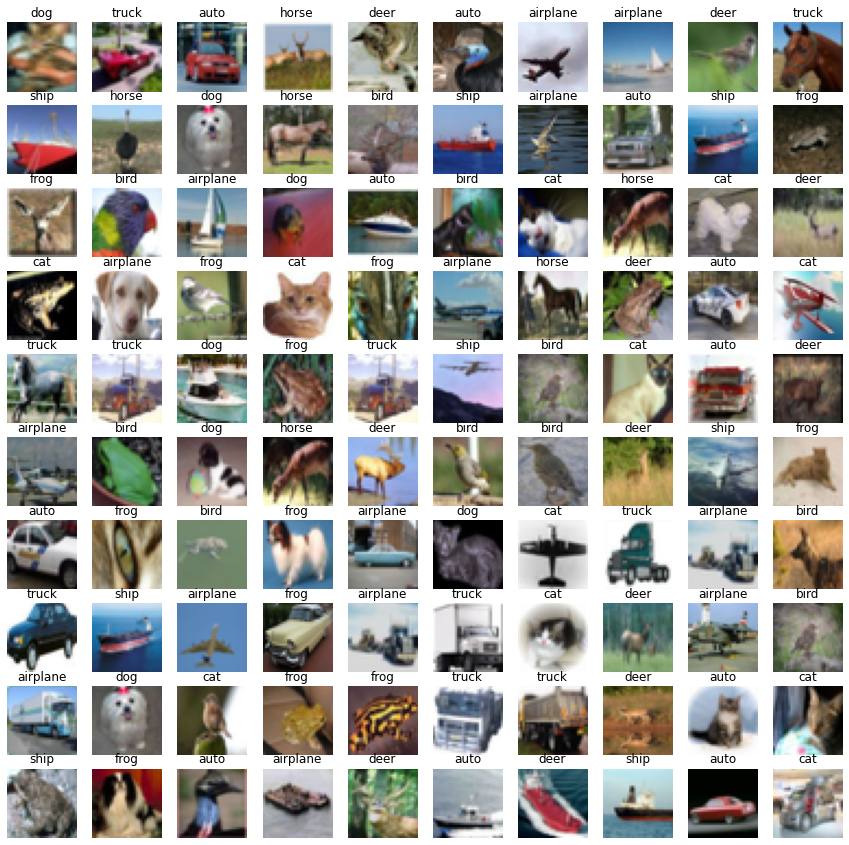

In [126]:
indices = np.random.randint(len(X_wrong),size = 100)

plt.figure(figsize=(15,15))
for i in range(100):
    image = X_test[indices[i]].reshape(32,32,3)
    plt.subplot(10,10,i+1)
    plt.imshow(image)
    plt.title(classes[y_test_pred[indices[i]]])
    plt.axis('off')

array([ 4, 31, 26, 50, 55, 14, 35, 41, 94, 28])

In [ ]:
Convolutional neural network

### Three layers

In [63]:
# neural network 
layer1 = layer(n_inputs = 3072, n_neurons = 200)
activation1 = activation_ReLU()
dropout1 = dropout(.4)

layer2 = layer(n_inputs = 200, n_neurons = 150)
activation2 = activation_ReLU()
dropout2 = dropout(.4)

layer3 = layer(n_inputs = 150, n_neurons = 10)
activation3 = activation_softmax()
loss_function = loss_crossentropy()

In [64]:
# optimizer
optimizer = optimizer_Adam()

In [65]:
n_epochs = 500
loss_adam = np.zeros(n_epochs)
accuracy_adam = np.zeros(n_epochs)
for i in range(n_epochs):
    
    # forward pass
    layer1.forward(X_train)
    activation1.forward(layer1.output)
    dropout1.forward(activation1.output)
    
    layer2.forward(dropout1.output)
    activation2.forward(layer2.output)
    dropout2.forward(activation2.output)
    
    layer3.forward(dropout2.output)
    activation3.forward(layer3.output)
    
    # loss
    losses = loss_function.forward(activation3.output,y_train)
    loss_adam[i] = np.mean(losses)
    
    # accuracy
    y_pred = np.argmax(activation3.output,axis=1)
    accuracy_adam[i] = 100*np.sum(y_pred == y_train)/len(y_train)
    
    # backward pass
    loss_function.backward(activation3.output,y_train)
    activation3.backward(loss_function.dinputs)
    layer3.backward(activation3.dinputs)
    
    dropout2.backward(layer3.dinputs)
    activation2.backward(dropout2.dinputs)
    layer2.backward(activation2.dinputs)
    
    dropout1.backward(layer2.dinputs)
    activation1.backward(dropout1.dinputs)
    layer1.backward(activation1.dinputs)
    
    # update weights and biases
    optimizer.pre_update_parameters()
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.update_parameters(layer3)
    optimizer.post_update_parameters()
    
    # print loss and accuracy every 100 epochs
    if i % 100 == 0:
        print('epoch: '+str(i))
        print('loss: '+str(np.round(loss_adam[i],3)))
        print('accuracy: '+str(np.round(accuracy_adam[i],3)))
        print('------------------------')

epoch: 0
loss: 2.655
accuracy: 10.42
------------------------
epoch: 100
loss: 1.927
accuracy: 28.02
------------------------
epoch: 200
loss: 1.932
accuracy: 27.66
------------------------
epoch: 300
loss: 1.926
accuracy: 26.3
------------------------
epoch: 400
loss: 1.92
accuracy: 26.94
------------------------


KeyboardInterrupt: 

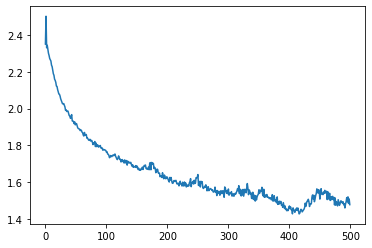

In [57]:
plt.plot(loss_adam)

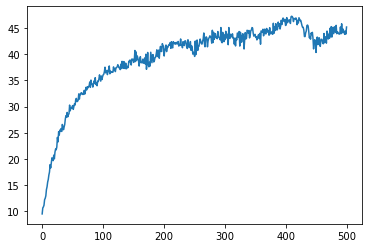

In [58]:
plt.plot(accuracy_adam)

In [59]:
# forward pass
layer1.forward(X_test)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)
layer3.forward(activation2.output)
activation3.forward(layer3.output)

In [60]:
y_test_pred = np.argmax(activation3.output,axis=1)

In [61]:
100*np.sum(y_test==y_test_pred)/len(y_test)

35.2

In [62]:
C = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        C[i,j] = np.sum(y_test[y_test_pred==i]==j)
        
C

array([[ 76.,  25.,  34.,  15.,  12.,   7.,   3.,  20.,  33.,  15.],
       [ 10.,  79.,   4.,  13.,   4.,  11.,   5.,   7.,  16.,  40.],
       [  9.,   6.,  50.,  17.,  41.,  22.,  24.,  14.,   2.,   6.],
       [  3.,  11.,  15.,  40.,  10.,  28.,  25.,  10.,   5.,   8.],
       [  2.,   3.,  25.,  15.,  47.,   9.,  17.,  18.,   0.,   1.],
       [  6.,   7.,  16.,  43.,  22.,  66.,  26.,  17.,   9.,   5.],
       [  1.,   9.,  23.,  31.,  29.,  13.,  89.,  18.,   2.,  10.],
       [  5.,   8.,  12.,   8.,  17.,  14.,   5.,  87.,   7.,  22.],
       [ 67.,  25.,  16.,  20.,  14.,  10.,   6.,  10., 108.,  40.],
       [  9.,  25.,   5.,   8.,   4.,   3.,   6.,  15.,   8.,  62.]])